### 载入数据

In [1]:
import pandas as pd
df = pd.read_excel("city.xls")
df.head()

,省份,地市,区县,经度,纬度
0,北京市,北京市,北京市,116.40,39.90
1,北京市,北京市,天安门,116.38,39.90
2,北京市,北京市,东城区,116.42,39.93
3,北京市,北京市,西城区,116.37,39.92
4,北京市,北京市,崇文区,116.43,39.88


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3183 entries, 0 to 3182
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   省份      3183 non-null   object 
 1   地市      3179 non-null   object 
 2   区县      3179 non-null   object 
 3   经度      3179 non-null   float64
 4   纬度      3179 non-null   float64
dtypes: float64(2), object(3)
memory usage: 124.5+ KB


### 手动实现的kmeans算法

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(43)  # 设置随机种子
def L2(vecXi, vecXj):
    '''
    计算欧氏距离
    para vecXi：点坐标，向量
    para vecXj：点坐标，向量
    retrurn: 两点之间的欧氏距离
    '''
    return np.sqrt(np.sum(np.square(vecXi - vecXj)))

In [3]:
def update_center_point(S, sampleTag, k):
    """
    返回更新之后的点
    """
    center_points = []
    for i in range(k):
        cluster_point = []
        # 将所有属于同一簇的点放入数组
        for j in range(len(sampleTag)):
            if sampleTag[j] == i:
                cluster_point.append(S[j])
        
        cluster_point = np.array(cluster_point)
        center_point = np.sum(cluster_point,axis=0) * 1 / (len(cluster_point))
        center_points.append(center_point)
    return center_points

In [4]:
def isChange(center_points, pred_center_points, tol=1e-4):
    """
    判断中心点是否发生改变
    """
    for i in range(len(center_points)):
        if pred_center_points[i][0] != center_points[i][0]:
            return True
        elif pred_center_points[i][1] != center_points[i][1]:
            return True
    return False
    # return np.any(np.linalg.norm(np.array(center_points) - np.array(pred_center_points), axis=1) > tol)

In [5]:
def kMeans(S, k, distMeas=L2):
    '''
    K均值聚类
    para S：样本集，多维数组
    para k：簇个数
    para distMeas：距离度量函数，默认为欧氏距离计算函数
    return sampleTag：一维数组，存储样本对应的簇标签
    return clusterCents：一维数组，各簇中心
    retrun SSE:误差平方和
    '''
    is_change = True
    #  初始化：随机选取k各数据点作为中心
    random_index = np.random.choice(len(S), k, replace=False)
    center_points = [S[i] for i in random_index]
    
    while(is_change):
        pred_center_points = center_points
        #  对于每个数据点，计算到每个簇中心的距离
        SSE_all_point = []
        sampleTag = []
        for point in S:
            dis_i = np.array([])
            for i in range(k):
                center_point = center_points[i]
                distance = distMeas(point, center_point)
                dis_i = np.append(dis_i, distance)

            sampleTag.append(np.argmin(dis_i))
            SSE_all_point.append(np.min(dis_i)**2)
        
        # 计算每个簇的中心
        center_points = update_center_point(S,sampleTag, k)
        SSE = np.sum(SSE_all_point)
        
        # 判断中心点有无发生改变
        is_change = isChange(center_points, pred_center_points)
    return center_points, sampleTag, SSE

### 根据城市的经纬度进行聚类

#### 采用自己实现的方法

In [6]:
# 获取数据
longitude, latitude = df['经度'].dropna(), df['纬度'].dropna() 
data = np.c_[longitude, latitude]
print(data.shape)
print(data)



(3179, 2)
[[116.4   39.9 ]
 [116.38  39.9 ]
 [116.42  39.93]
 ...
 [121.15  22.75]
 [121.6   23.98]
 [119.58  23.58]]


In [8]:
# 计算inertia，然后找到合适的簇树
# 大致需要一分半
inertia_per_k = [kMeans(data, k)[2] for k in range(1,20)]
print(inertia_per_k)

[424822.11008713435, 247651.50675883974, 169306.19618657403, 111982.57234854109, 78991.8702696436, 64981.997160733794, 54267.40656543764, 46280.89318739451, 41055.56207236007, 41204.544607306685, 33392.811434362164, 30593.454947806447, 28376.780641699046, 26451.351773793253, 24112.123157313712, 22634.727944351314, 22287.844552676255, 20539.530265052017, 18479.102159178354]


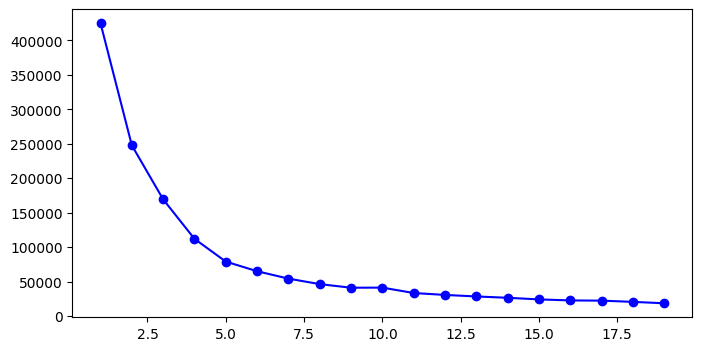

In [10]:
plt.figure(figsize=(8,4))
plt.plot(range(1,20), inertia_per_k, 'bo-')
plt.show()


In [25]:
# 从图像观察而得，k选取5比较合适
k = 5
center_points, sampleTag, SSE = kMeans(data, k)

#### 使用轮廓系数来判断合适簇数字

In [9]:
from sklearn.metrics import silhouette_score
silhouette_scores = [silhouette_score(data,kMeans(data, k)[1] )for k in range(4,10)]

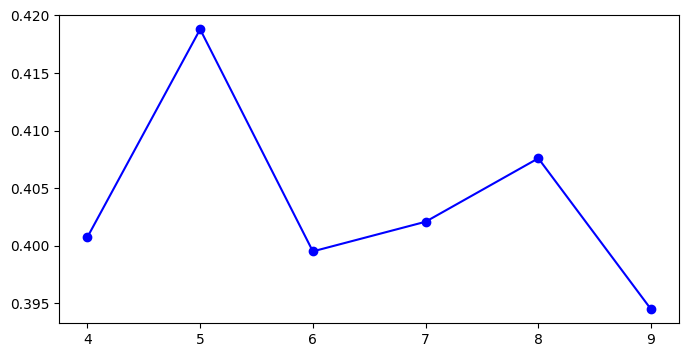

In [10]:
plt.figure(figsize=(8,4))
plt.plot(range(4,10), silhouette_scores, 'bo-')
plt.show()

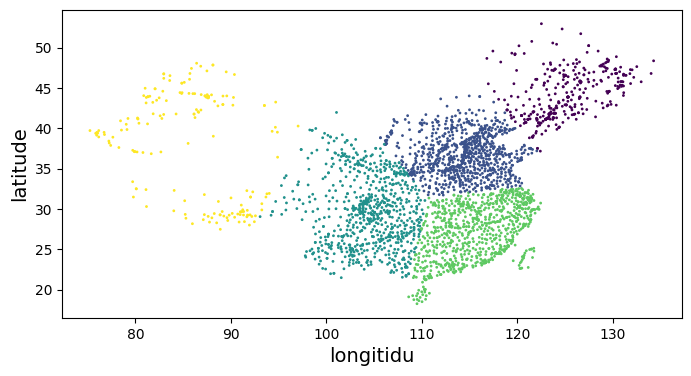

In [26]:
# 可视化聚类结果
def plot_clusters(X, y=None):
    plt.scatter(X[:, 0], X[:, 1], c=y, s=1)
    plt.xlabel('longitidu',fontsize=14)
    plt.ylabel('latitude',fontsize=14)

plt.figure(figsize=(8,4))
plot_clusters(data, sampleTag)
plt.show()
    

#### 采用sklearn实现的方法

In [11]:
from sklearn.cluster import KMeans
kmeans_per_k = [KMeans(n_clusters = k).fit(data) for k in range(1,20)]
inertias = [model.inertia_ for model in kmeans_per_k]
print(inertias)

c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of

[424822.1100871344, 247668.77293586393, 161528.57025693485, 111983.18096035557, 78992.41217090536, 64458.60288147616, 54151.23104748724, 46274.56152923138, 41054.745425839, 37255.29555194167, 33394.0942307023, 30566.73301286355, 27700.519114472103, 25375.21391551853, 23453.6233022828, 21520.49402768973, 20253.672506721563, 18921.707888372584, 18040.749700986824]


c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


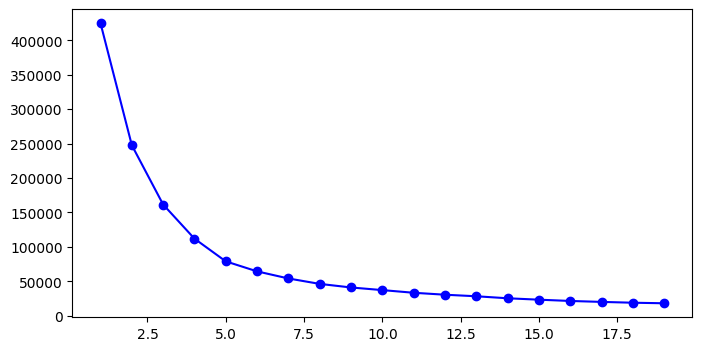

In [19]:
plt.figure(figsize=(8,4))
plt.plot(range(1,20),inertias,'bo-')
plt.show()


In [27]:
model = KMeans(n_clusters=5)
model.fit(data)
model.labels_

c:\Anaconda3\envs\opencv\lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


array([0, 0, 0, ..., 2, 2, 2])

In [28]:
silhouette_scores = [silhouette_score(data, model.labels_) for model in kmeans_per_k[1:]]

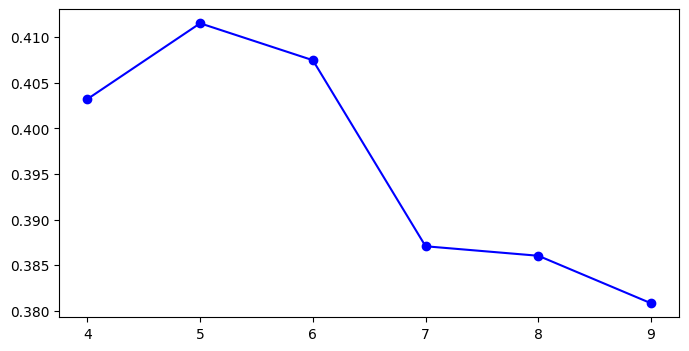

In [24]:
plt.figure(figsize=(8,4))
plt.plot(range(4,10), silhouette_scores[4:10], 'bo-')
plt.show()

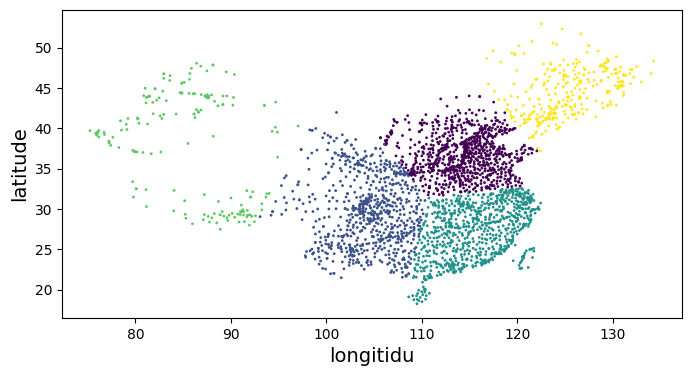

In [29]:
plt.figure(figsize=(8,4))
plot_clusters(data, y=model.labels_)

由图像可得，选取k=5也较为合适，与手动实现的算法得出结果一致

### 使用手动实现的算法对一张图片进行聚类

In [ ]:
from PIL import Image

image_path = './企鹅.jpg'
image = Image.open(image_path)

image_array = np.array(image)
width, height = image_array.shape[0], image_array.shape[1]
print(image_array.shape)

(467, 700, 3)


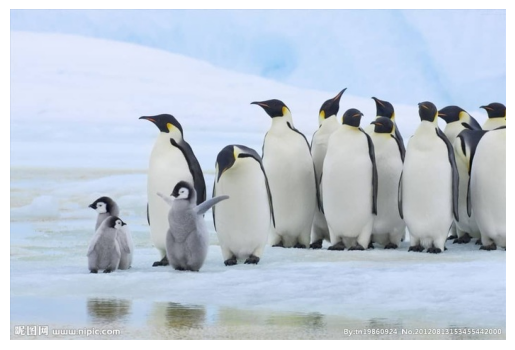

In [ ]:
# 显示原始图片
plt.imshow(image_array)
plt.axis('off')
plt.show()

In [ ]:
# k=2
# 这里的Kmeans是手动实现的算法，可能速度较慢,大致需要2分半
image_data = image_array.reshape((-1,2))
center_points, sampleTag, SSE = kMeans(S=image_data, k=2)

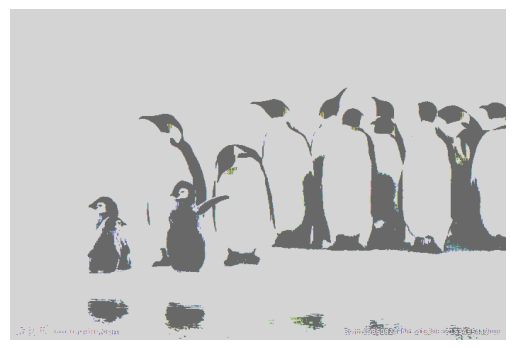

In [ ]:
# 根据聚类中心进行分组，并将分组后的数据重新排列成图片的形状
center_points = np.array(center_points)
image_clustered = center_points[sampleTag].reshape((width, height, -1))
image_clustered = np.clip(image_clustered, 0, 255).astype(np.uint8)

plt.imshow(image_clustered)
plt.axis('off')
plt.show()